<a href="https://colab.research.google.com/github/massirism/PDI-UNS/blob/main/TP7_Massiris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Miguel Massiris - TP7

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

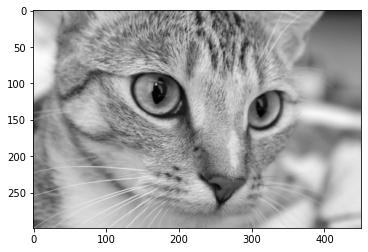

In [3]:
img_rgb=imageio.imread('imageio:chelsea.png')/255
img_gray=rgb2yiq(img_rgb)[:-1,:,0]

plt.imshow(img_gray, 'gray')

**Remuestreo, reconstrucción y cuantización**

Para cada uno de los siguientes incisos, definir una función que haga las tareas especificadas sobre una imagen en escala de grises.

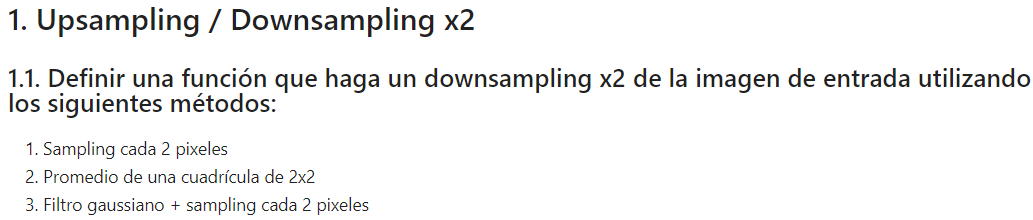

#1. Sampling cada 2 pixeles

In [4]:
def downsampling_x2(img):
  if (img.ndim==2):
    #print("Gray")
    aux=img[::2,::2]  #Primer downsampling
    aux=aux[::2,::2]  #Segundo downsampling
    return aux
  else:
    print("Ingrese una imagen en escala de grises")

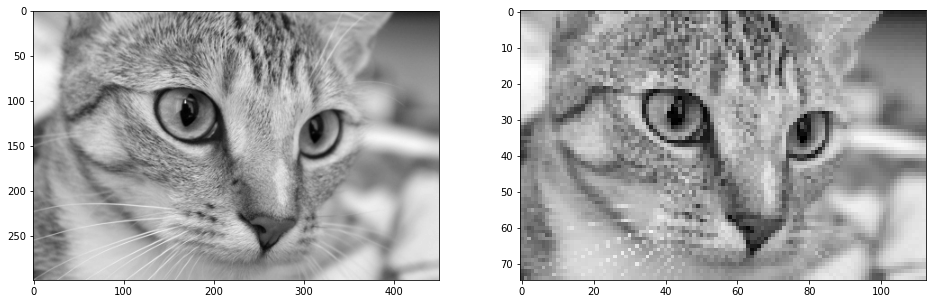

In [5]:
img_res=downsampling_x2(img_gray)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#2. Promedio de una cuadricula 2x2

In [6]:
def downsampling_avg(img):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Uso estos valores para la nueva imagen
  width=(original_width//2)
  height=(original_height//2)
  resized_image=np.zeros(shape=(height, width))

  scale=2 #Cuadricula de 2*2
  for i in range(0, original_height, scale):
    for j in range(0, original_width, scale):
     if (i+1<height*scale) & (j+1<width*scale): #Para verificar que no se salga del contorno
       resized_image[i//scale, j//scale] = np.mean(img[i:i+scale,j:j+scale], axis=(0,1))
       #Hago el promedio en la nueva imagen

  return resized_image

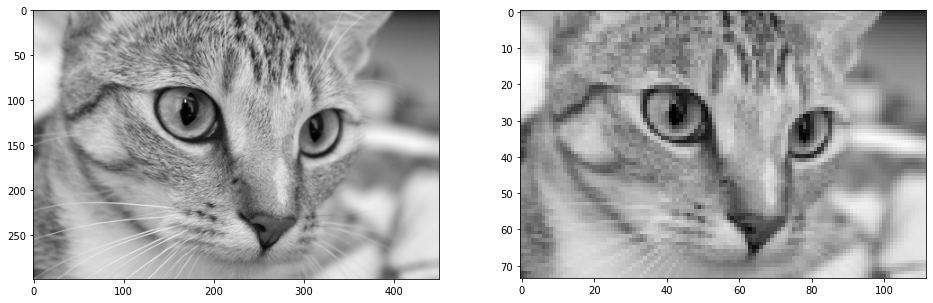

In [7]:
img_res=downsampling_avg(downsampling_avg(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#3. Filtro gaussiano + sampling cada 2 pixeles

In [8]:
#Es una función auxiliar para calcular la densidad utilizando la fórmula de la distribución normal univariante
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

In [9]:
def Kernel_Gaussian(size, sigma=1):
  #Creo el kernel unidimensional con el size dado por el usuario
  kernel_1D=np.linspace(-(size//2), size//2, size)
  for i in range(size):
    #Aplico la función aux
    kernel_1D[i]=dnorm(kernel_1D[i], 0, sigma)

  #Paso el kernel de una dimension a uno de dos haciendo el producto exterior
  kernel_2D=np.outer(kernel_1D.T, kernel_1D.T)
 
  kernel_2D*=(1.0/kernel_2D.max())
  return kernel_2D

N,std=7,10
kernel_gaussian=Kernel_Gaussian(N,std)
#print(kernel_gaussian)

In [10]:
from scipy.signal import convolve2d
def downsampling_gaussian(img,kernel=kernel_gaussian):
  img_res_gaussian=convolve2d(img, kernel, boundary='symm', mode='same')
  img_res_gaussian_sampling=img_res_gaussian[::2,::2]
  return img_res_gaussian_sampling


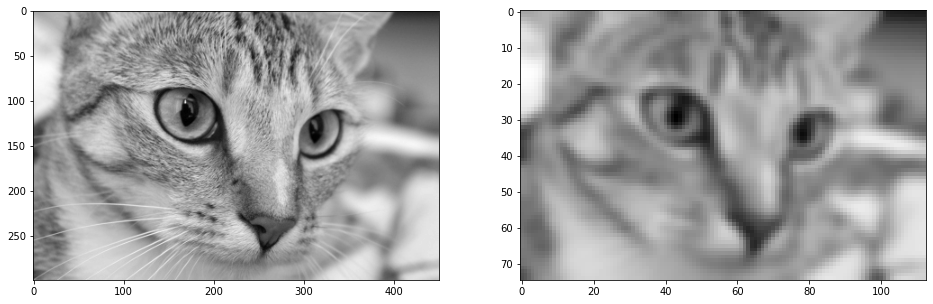

In [11]:
img_res=downsampling_gaussian(downsampling_gaussian(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

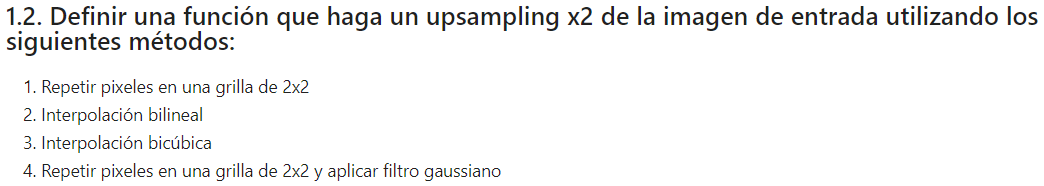

#1. Repetir pixeles en una grilla de 2x2

In [12]:
def upsampling(img):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Uso estos valores para la nueva imagen, esta vez es el doble
  width=(original_width*2)
  height=(original_height*2)
  resized_image=np.zeros(shape=(height, width))

  scale=2 #Cuadricula de 2*2
  for i in range(0, original_height*2, scale):  #Recorro el doble por eso multiplico por 2
    for j in range(0, original_width*2, scale):
      resized_image[i:i+2, j:j+2]=img[i//2,j//2]
     
  return resized_image

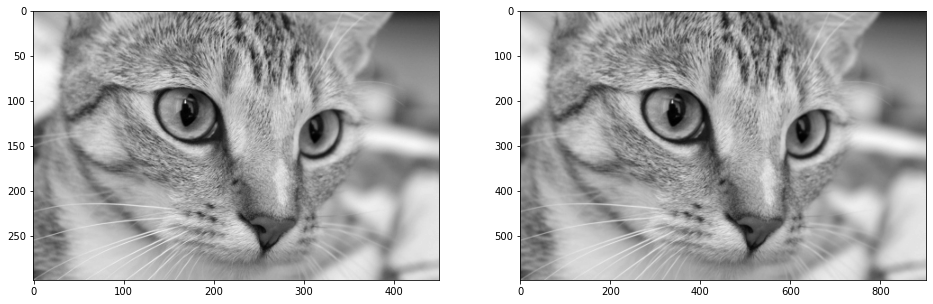

In [13]:
img_res=(upsampling(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#2. Interpolación bilineal

In [14]:
def upsampling_inter_bilineal(img):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Uso estos valores para la nueva imagen, esta vez es el doble
  width=(original_width*2)
  height=(original_height*2)
  resized_image=np.zeros(shape=(height, width))
  
  #Relleno la imagen 
  resized_image[::2,::2]=img

  #Creo el eje 
  arr_aux=[1/2, 1, 1/2]
  sec=np.expand_dims(arr_aux,1)
  kernel=np.matmul(sec, sec.T)
  resized_image=np.clip(convolve2d(resized_image, kernel, 'same', 'symm'),0,1)

  return resized_image

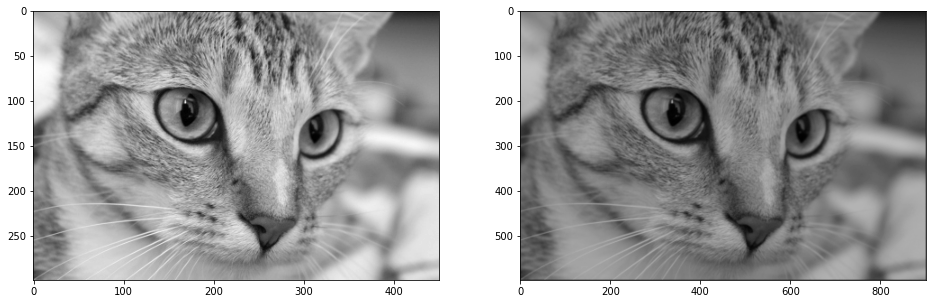

In [15]:
img_res=(upsampling_inter_bilineal(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#3. Interpolacion bicúbica

In [16]:
def upsampling_inter_bicubica(img):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Uso estos valores para la nueva imagen, esta vez es el doble
  width=(original_width*2)
  height=(original_height*2)
  resized_image=np.zeros(shape=(height, width))
  
  #Relleno la imagen 
  resized_image[::2,::2]=img

  #Creo el eje 
  arr_aux=[-1/8, 0, 5/8, 1, 5/8, 0, -1/8]
  sec=np.expand_dims(arr_aux,1)
  kernel=np.matmul(sec, sec.T)
  resized_image=np.clip(convolve2d(resized_image, kernel, 'same', 'symm'),0,1)

  return resized_image

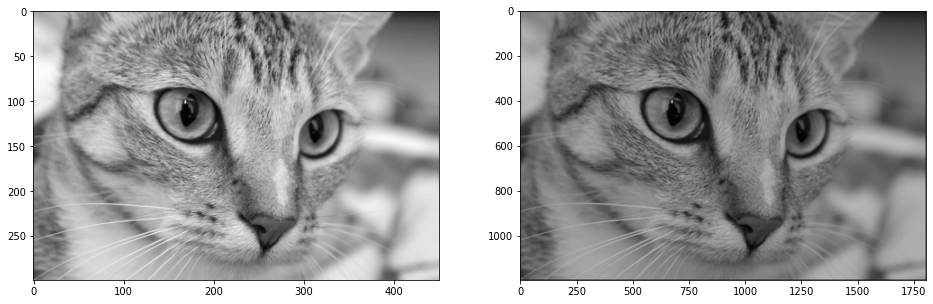

In [17]:
img_res=upsampling_inter_bicubica(upsampling_inter_bicubica(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#4. Repetir pixeles en una grilla de 2x2 y aplicar filtro gaussiano

In [18]:
def upsampling_gaussian(img,kernel=kernel_gaussian):
  img_aux=upsampling(img)
  #Utilizo el mismo kernel que cree para el downsampling
  img_res=convolve2d(img_aux, kernel, 'same', 'symm')
  return img_res

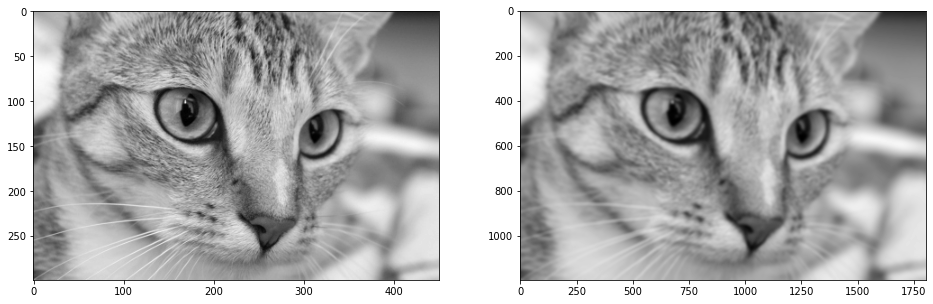

In [19]:
img_res=upsampling_gaussian(upsampling_gaussian(img_gray))  #Les estoy aplicando 2 porque apenas y se nota

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

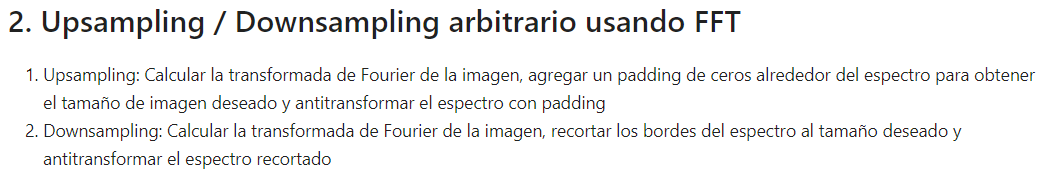

# Upsampling/Downsampling usando FFT

In [23]:
def redimensionar_fft(img,ancho_deseado,largo_deseado):
  #Aplico la transformada rápida de Fourier a la imagen
  n_pixeles=np.prod(img.shape[0:2])
  img_aux=(1/n_pixeles)*(np.fft.fftshift(np.fft.fft2(img)))
  #Delta de alto y ancho
  delta_alto=largo_deseado-img.shape[0]
  delta_ancho=ancho_deseado-img.shape[1]

  #Rellenar o recortar el ancho, con ceros si es necesario...
  if (delta_ancho>0):
    img_aux=np.pad(img_aux,((0,0),(delta_ancho//2, delta_ancho//2)))
  elif (delta_ancho<0):
    img_aux=img_aux[:,-delta_ancho//2:delta_ancho//2+1]  

  #Dar más altura o recortarla
  if (delta_alto)>0:
    img_aux=np.pad(img_aux,((delta_alto//2,delta_alto//2), (0,0)))
  elif (delta_alto)<0:
    img_aux=img_aux[-delta_alto//2:delta_alto//2+1,:]

  #Aplicar la TIF
  n_pix_act=largo_deseado*ancho_deseado
  img_res=np.fft.ifft2(np.fft.ifftshift(img_aux*n_pix_act))
  img_res=np.clip(np.real(img_res),0,1)
  return img_res

Ingrese el largo deseado: 0
Ingrese el ancho deseado: 0
Pruebe con un número positivo
Ingrese el largo deseado: 0
Ingrese el ancho deseado: 2
Pruebe con un número positivo
Ingrese el largo deseado: 3
Ingrese el ancho deseado: 0
Pruebe con un número positivo
Ingrese el largo deseado: 5
Ingrese el ancho deseado: 5


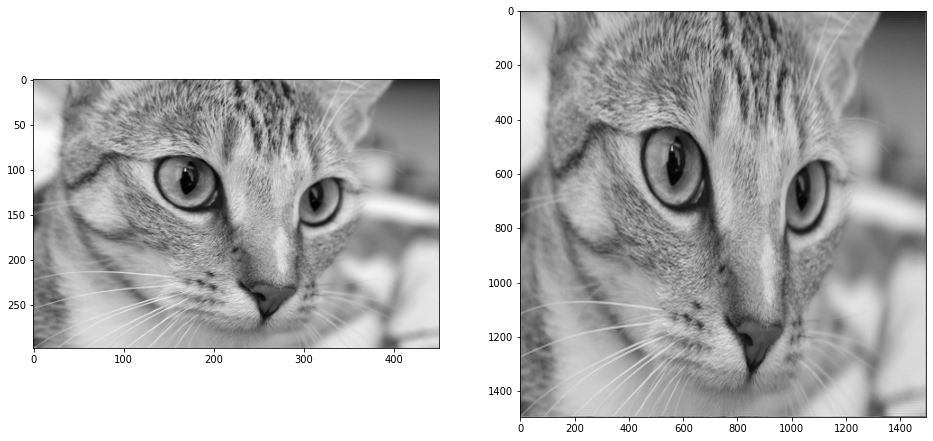

In [25]:
largo_deseado=int(input("Ingrese el largo deseado: ")) 
ancho_deseado=int(input("Ingrese el ancho deseado: ")) 
while (largo_deseado<=0) or (ancho_deseado<=0):
  print("Pruebe con un número positivo")
  largo_deseado=int(input("Ingrese el largo deseado: ")) 
  ancho_deseado=int(input("Ingrese el ancho deseado: ")) 

ancho_aux=img_gray.shape[0]*ancho_deseado
largo_aux=img_gray.shape[0]*largo_deseado


img_res=redimensionar_fft(img_gray,ancho_aux,largo_aux) 

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

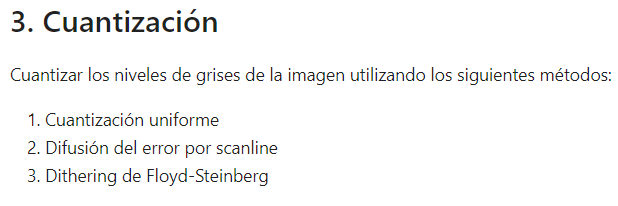

#1. Cuantización uniforme

In [35]:
def cuantizacion_uniforme(img,niveles,maxCount=255):
    # El numero max de niveles son 255, por las dimensiones de la imagen
    if((niveles>1) and (niveles<maxCount)):
        niveles=niveles-1
        img_res=np.round(img*(niveles))/(niveles)
    else:
        print("los niveles a cuantizar debe ser mayor a 1 y menor a 255")
        img_res=img

    return img_res


Ingrese el numero de niveles de cuantización: 2


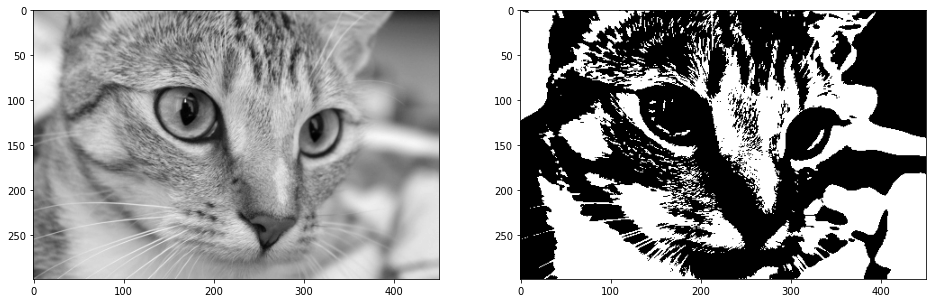

In [39]:
n=int(input("Ingrese el numero de niveles de cuantización: ")) 

img_res=cuantizacion_uniforme(img_gray,n) 

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#2. Difusión del error por scaline

In [40]:
def dif_err_scaline(img,niveles):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Hago una imagen auxiliar para modificarla
  img_aux=np.array(img, dtype=float)
  # Recorrer filas y columnas
  for h in range(original_height):
    error=0
    for w in range(original_width):
      original_pixel=img_aux[h,w].copy()
      pixel_modificado=np.round(original_pixel*(niveles-1)+error)/(niveles-1)
      img_aux[h,w]=pixel_modificado
      error=error+original_pixel-pixel_modificado

  return img_aux

Ingrese el numero de niveles de cuantización: 3


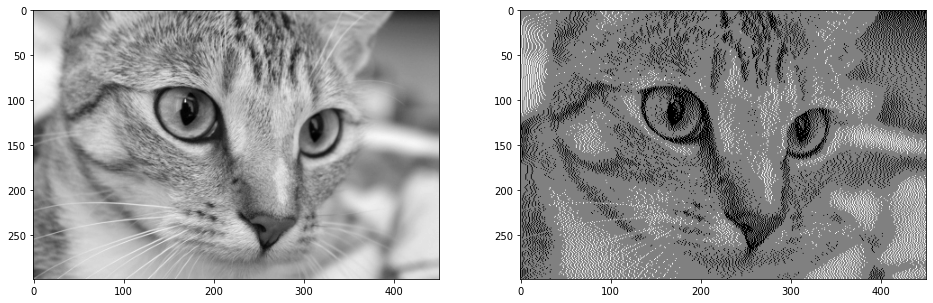

In [41]:
n2=int(input("Ingrese el numero de niveles de cuantización: ")) 

img_res=dif_err_scaline(img_gray,n2) 

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')

#3. Dithering de Floyd-Steinberg

In [45]:
def floyd_steinberg_dithering(img, levels):
  #Tomo los valores de la dimension de la imagen
  original_width=img.shape[1]
  original_height=img.shape[0]

  #Hago una imagen auxiliar para modificarla
  img_aux=np.array(img, dtype=float)

  for i in range(0, original_height-1):
      for j in range(0, original_width-1):
        oldpixel=img_aux[i,j].copy()
        newpixel=np.round(oldpixel*(levels-1))/(levels-1)
        img_aux[i,j]=newpixel
        error=oldpixel-newpixel
        img_aux[i+1,j]+= error*(7/16)
        img_aux[i-1,j+1]+= error*(3/16)
        img_aux[i,j+1]+= error*(5/16)
        img_aux[i+1,j+1]+= error*(1/16)

  return img_aux


Ingrese el numero de niveles de cuantización: 2


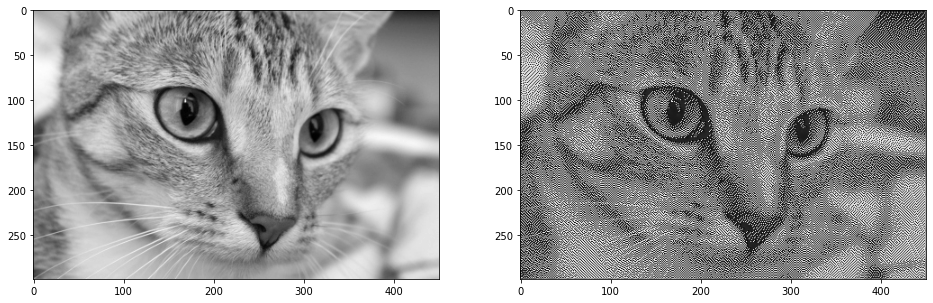

In [46]:
n3=int(input("Ingrese el numero de niveles de cuantización: ")) 

img_res=floyd_steinberg_dithering(img_gray,n3) 

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_res, 'gray')